# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import sys
from nltk.corpus import stopwords
import nltk
import gensim
from gensim.models import ldamodel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize
import pickle
import re
import spacy
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import en_core_web_sm

In [2]:
df = pd.read_json(r'C:\Users\Aishwik\Downloads\product-review-summarization-project\Cell_Phones_and_Accessories.json')
df.head()

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None
1,5,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None
2,5,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None
3,3,True,"02 27, 2013",B0089CH3TM,{'Color:': ' Green'},Alyse,"The material and fit is very nice, but the col...",Good case overall,1361923200,3,None
4,4,True,"12 19, 2013",B00AKZWGAC,None,TechGuy,This last me about 3 days till i have to charg...,Awesome Battery,1387411200,None,None


# Data Cleaning and EDA

In [3]:
df.shape

(760450, 11)

In [4]:
df.isnull().sum()

Rating                   0
Rev_verify               0
Review_Date              0
IC                       0
Prod_meta           352624
Reviewer_Name           91
Review                 530
Rev_summ               355
Review_timestamp         0
Useful              698250
Prod_img            742256
dtype: int64

In [5]:
df.duplicated('IC').sum()

712316

In [6]:
df = df.dropna(axis=0, subset=['Review'])

In [7]:
df.isnull().sum()

Rating                   0
Rev_verify               0
Review_Date              0
IC                       0
Prod_meta           352384
Reviewer_Name           90
Review                   0
Rev_summ               318
Review_timestamp         0
Useful              697743
Prod_img            741786
dtype: int64

In [8]:
df.Rev_summ = df.Rev_summ.fillna(df.Review) #fillng null 'Rev_summ' rows with text from 'Review'.

In [9]:
df.isnull().sum()

Rating                   0
Rev_verify               0
Review_Date              0
IC                       0
Prod_meta           352384
Reviewer_Name           90
Review                   0
Rev_summ                 0
Review_timestamp         0
Useful              697743
Prod_img            741786
dtype: int64

In [10]:
df['Rev_summ_']=df['Rev_summ'].str[:] + ' '   #adding space in each line for properly aggrgating the text according to item code. 


In [11]:
df.head(1)

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img,Rev_summ_
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None,He's very happy with


In [12]:
df6 = df.groupby(['IC']).agg({'Rev_summ_': 'sum'}).sort_values(by= 'IC', ascending = True)

In [13]:
df6['totalwords'] = df6['Rev_summ_'].str.split().str.len()
df6.head()

,Rev_summ_,totalwords
IC,,
7508492919,I love it I didn't get the same case that's sh...,97
7532385086,A waste of money! htc evo cover better than ex...,21
7887421268,Five Stars good deal Five Stars Loved it at fi...,33
8199900164,Five Stars I item didn't work Five Stars,8
8288853439,GOOD BUY Galaxy S4 Charger LIAR Four Stars gre...,22


In [14]:
df6[df6['totalwords']>30].count()

Rev_summ_     24548
totalwords    24548
dtype: int64

In [15]:
#removing stopwords
df6['Rev_summ']=df6['Rev_summ_'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word.lower() not in stopwords.words("english")))

In [16]:
df6['totalwords_wo_spw'] = df6['Rev_summ'].str.split().str.len()
df6[df6['totalwords_wo_spw']>30].count()

Rev_summ_            17502
totalwords           17502
Rev_summ             17502
totalwords_wo_spw    17502
dtype: int64

In [17]:
df6["Rev_summ"] = df6['Rev_summ'].str.replace('[^\w\s]','')  #removing punctuations

In [18]:
df6.head()

,Rev_summ_,totalwords,Rev_summ,totalwords_wo_spw
IC,,,,
7508492919,I love it I didn't get the same case that's sh...,97,love get case thats shown pretty 1 cute cute ...,72
7532385086,A waste of money! htc evo cover better than ex...,21,waste money htc evo cover better expected expe...,14
7887421268,Five Stars good deal Five Stars Loved it at fi...,33,five stars good deal five stars loved first gr...,26
8199900164,Five Stars I item didn't work Five Stars,8,five stars item work five stars,6
8288853439,GOOD BUY Galaxy S4 Charger LIAR Four Stars gre...,22,good buy galaxy s4 charger liar four stars gre...,22


# Items and their max, mean, min ratings

In [19]:
df2 = df.groupby(['IC']).agg({'Rating': 'max'}).sort_values(by= 'IC', ascending = True)

In [20]:
df2.rename(columns={"Rating": "Max Rating"}, inplace =True)
df2

,Max Rating
IC,
7508492919,5
7532385086,5
7887421268,5
8199900164,5
8288853439,5
...,...
B01HJBS5C2,5
B01HJC7N4C,5
B01HJCN1UC,5


In [21]:
df3 = df.groupby(['IC']).agg({'Rating': 'mean'}).sort_values(by= 'IC', ascending = True)

In [22]:
df3.rename(columns={"Rating": "Mean Rating"}, inplace =True)
df3.head(2)

,Mean Rating
IC,
7508492919,4.300000
7532385086,3.285714


In [23]:
df4 = df.groupby(['IC']).agg({'Rating': 'min'}).sort_values(by= 'IC', ascending = True)

In [24]:
df4.rename(columns={"Rating": "Min Rating"}, inplace =True)
df4.head(2)

,Min Rating
IC,
7508492919,1
7532385086,1


In [25]:
df5=pd.concat([df2,df3,df4], axis=1)

In [26]:
df5.reset_index(level='IC', inplace=True)

In [27]:
df5

,IC,Max Rating,Mean Rating,Min Rating
0,7508492919,5,4.300000,1
1,7532385086,5,3.285714,1
2,7887421268,5,3.538462,1
3,8199900164,5,3.750000,2
4,8288853439,5,3.818182,1
...,...,...,...,...
48128,B01HJBS5C2,5,3.250000,1
48129,B01HJC7N4C,5,4.600000,3
48130,B01HJCN1UC,5,4.727273,4
48131,B01HJCN55I,5,4.454545,2


In [28]:
df5.sort_values(by = 'Mean Rating', ascending = False)

,IC,Max Rating,Mean Rating,Min Rating
34542,B00ZQ9MD82,5,5.0,5
40681,B018HANVTQ,5,5.0,5
5878,B007870GVG,5,5.0,5
28421,B00QW3H62E,5,5.0,5
28417,B00QW1U3L2,5,5.0,5
...,...,...,...,...
624,B0016I8GV0,1,1.0,1
37680,B0151HF1FA,1,1.0,1
39960,B017JPPYXG,1,1.0,1
28900,B00RMA6Q6S,1,1.0,1


In [29]:
# Convert to list
data = df6.Rev_summ.values.tolist()

# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]

from pprint import pprint
pprint(data[:1])

['love get case thats shown pretty 1 cute cute bingbling love cute tightt four '
 'stars crystal bow case cute great gift love invisible case adorable gonna '
 'order rest love case beautiful luv luv luv sara cant stop using case bling '
 'cute bling bling iphone 4s bling worth great price cute sparkly good love '
 'phone cover pretty cute amazing great cheap plastic okay 4s phone case loves '
 'it great bow case']


In [30]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations, though already removed before cell [28] 
data_words = list(sent_to_words(data))
print(data_words[:1])

[['love', 'get', 'case', 'thats', 'shown', 'pretty', 'cute', 'cute', 'bingbling', 'love', 'cute', 'tightt', 'four', 'stars', 'crystal', 'bow', 'case', 'cute', 'great', 'gift', 'love', 'invisible', 'case', 'adorable', 'gonna', 'order', 'rest', 'love', 'case', 'beautiful', 'luv', 'luv', 'luv', 'sara', 'cant', 'stop', 'using', 'case', 'bling', 'cute', 'bling', 'bling', 'iphone', 'bling', 'worth', 'great', 'price', 'cute', 'sparkly', 'good', 'love', 'phone', 'cover', 'pretty', 'cute', 'amazing', 'great', 'cheap', 'plastic', 'okay', 'phone', 'case', 'loves', 'it', 'great', 'bow', 'case']]


In [31]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [32]:
nlp = en_core_web_sm.load()

# lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

['love get case s show bingble love bow case gift love case go order rest love case can stop use case ble bling ble ble price love phone cover plastic phone case love bow case', 'money cover expect expect star star love product']


In [33]:
vectorizer = CountVectorizer(analyzer='word', min_df=10,   # minimum reqd occurences of a word 
                             stop_words='english',         # remove stop words
                             lowercase=True,              # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}' # num chars > 3             
                             ) 
                             
data_vectorized = vectorizer.fit_transform(data_lemmatized)

# Modeling

In [34]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                      )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [35]:
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method='online', learning_offset=10.0,
 max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
 n_components=10, n_jobs=-1, perp_tol=0.1,
 random_state=100, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)

In [36]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -5283455.069207553
Perplexity:  132.6131060849195
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [37]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
        iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             iid=True, n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 25, 30]},
             return_train_score='warn')

In [38]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -1050565.2398560022
Model Perplexity:  114.70501898446084


In [41]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,aaa,ability,absolute,absorb,absorption,abuse,acase,accent,accept,access,...,yesterday,youtube,yup,zagg,zenfone,zenwatch,zip,zipper,zone,zoom
Topic0,0.100107,0.100025,0.100054,0.100007,0.100037,0.100020,0.100009,0.100015,11.830469,0.100044,...,10.669357,0.100031,0.100028,0.100006,0.100236,0.100002,0.100008,0.100017,0.100053,0.100017
Topic1,0.100050,0.100021,0.100003,0.100023,0.100026,0.100022,0.100000,0.100011,0.100052,0.100592,...,0.100022,0.100072,0.100007,0.100008,20.601270,0.100095,10.400609,0.100014,0.100010,0.100005
Topic2,0.100048,0.100033,0.100012,39.091748,0.100047,71.660977,0.100025,0.100019,0.100025,0.100023,...,50.023342,0.100046,0.100013,0.100004,0.100027,0.100014,0.100005,30.238725,0.100013,28.918330
Topic3,0.100076,0.100048,0.100015,0.100006,0.100007,24.200061,0.100002,0.100013,0.100823,0.100014,...,0.100024,0.100038,10.845533,0.100097,0.100017,0.100028,0.100004,0.100011,0.100023,0.100062
Topic4,0.100054,0.100032,8.274388,0.100006,0.100063,0.105653,0.100009,24.637634,0.100080,14.916639,...,0.100020,0.100054,0.100039,0.100010,0.100046,0.100015,0.100010,0.100021,0.100020,0.100038


In [40]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(50).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.470000,0
Doc1,0.010000,0.010000,0.210000,0.010000,0.010000,0.010000,0.700000,0.010000,0.010000,0.010000,6
Doc2,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.460000,0.010000,0.180000,0.280000,6
Doc3,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.820000,0.020000,0.020000,0.020000,6
Doc4,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.450000,0.450000,0.010000,0.010000,6
Doc5,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.390000,0.550000,0.000000,0.000000,7
Doc6,0.180000,0.010000,0.010000,0.240000,0.010000,0.010000,0.010000,0.490000,0.010000,0.010000,7
Doc7,0.000000,0.000000,0.000000,0.070000,0.000000,0.050000,0.690000,0.170000,0.000000,0.000000,6
Doc8,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.370000,0.020000,0.020000,0.470000,9
Doc9,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.570000,0.350000,0.010000,0.010000,6


In [42]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=50)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

pd.set_option("display.max_rows", None, "display.max_columns", None)

df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49
Topic 0,phone,love,customer,cell,service,price,use,camera,smartphone,buy,android,update,issue,problem,feature,review,seller,device,samsung,value,ble,budget,company,year,window,month,grip,purchase,user,support,slot,want,read,app,upgrade,cellphone,market,opinion,money,gift,lumia,let,plan,make,level,experience,htc,need,kid,performance
Topic 1,watch,stand,apple,water,dock,look,gear,description,tablet,face,use,suction,remove,hit,dash,ask,owner,night,dashboard,place,damage,ipad,waterproof,inch,eye,windshield,include,lift,cradle,pop,fiber,mind,cup,gap,steel,sit,work,make,begin,peace,bonus,sport,mother,clamp,good,rate,key,heart,advertising,generation
Topic 2,break,otterbox,crack,cover,gift,week,box,tool,tell,clip,bulky,slide,deal,fun,rugge,lens,kit,love,expectation,photo,expect,picture,kid,piece,plastic,chip,meet,approve,lense,body,discount,buy,thing,prevent,commuter,save,shape,fix,defender,return,exceed,shatter,silver,print,win,pic,choose,problem,hole,thank
Topic 3,cable,work,note,quality,cord,charge,length,buy,make,usb,apple,samsung,month,product,lightning,charging,need,adapter,wire,connector,replacement,price,feel,foot,finish,connection,recommend,datum,brand,certify,oem,expect,end,plug,fit,transfer,nexus,carbon,premium,job,ipad,issue,break,problem,reach,sync,perfect,bend,skin,warranty
Topic 4,work,product,use,quality,love,price,design,buy,money,stick,make,headset,time,fit,recommend,need,thing,car,look,break,sound,set,item,device,stay,waste,selfie,try,advertise,job,month,fall,day,value,bluetooth,issue,review,headphone,build,moto,expect,end,piece,problem,life,size,speaker,junk,say,hand
Topic 5,hold,holder,mount,magnet,car,make,option,need,idea,work,lot,feature,place,way,model,leave,device,want,tech,help,cut,install,lack,air,hand,solution,video,concept,room,nee,view,support,think,functionality,throw,space,improvement,home,carry,fun,signal,handle,pull,consider,area,block,bit,electronic,base,mirror
Topic 6,star,work,product,love,buy,price,money,quality,recommend,look,item,phone,purchase,use,fit,deal,replacement,perfect,expect,thank,come,value,waste,time,need,seller,make,pay,job,order,samsung,disappoint,arrive,junk,card,like,advertise,say,thing,think,day,vent,receive,package,want,month,iphone,save,arm,problem
Topic 7,charge,charger,work,battery,product,power,device,anker,love,use,port,car,star,buy,pack,price,need,time,quality,travel,life,recommend,usb,size,look,plug,build,light,month,charging,make,capacity,design,stop,customer,day,service,advertise,fast,purchase,thing,value,come,unit,item,lot,samsung,review,expect,speed
Topic 8,screen,protector,product,glass,install,band,protection,star,quality,fit,look,apply,edge,bubble,protect,temper,buy,cover,price,feel,love,recommend,installation,scratch,come,use,instruction,time,application,shield,work,job,instal,save,touch,brand,make,try,need,drop,film,dust,value,plastic,finish,pack,fingerprint,way,purchase,stick
Topic 9,case,star,love,phone,look,protection,fit,color,price,quality,protect,feel,cover,product,buy,make,design,recommend,drop,button,use,wallet,grip,leather,edge,card,money,want,spigen,add,iphone,value,like,hold,provide,purchase,come,style,plastic,perfect,need,expect,belt,time,material,bumper,glove,scratch,hand,offer


In [70]:
Topics = ["feature phone/ happy user/ budget price/ value for money/ android update issue/ used phone/ customer support",
          "tablet/ apple/ ipad/ good look/ night dashboard/ face recognition/  waterproof/ used/ ask owner for description and if damaged",
          "slide/ otterbox/ approve/ good cover/ gift/ good deal/ good lens/ good photo/ fun/ plastic bulky body/ fun to use/ crack",
          "recommend / data connection/ brand value/ Samsung/ lightning fast charging/ quality cord/ cord length is short/ worth buying",
          "good fit/ response time/ quality product/ price/ design/ headset fits well/ good look/ sound breaks/ good selfie camera/ waste",
          "car charger/ magnet/ holder/ mount needed",
          "works well/ good price/ fits well/ nice look/ waste of time and money/don't expect replacement/ need seller",
          "good battery life/ device power/car port/ quality product/ good for travel life/ recommend/ light build/ fast charging", 
          "cover protector/ needs screen protector/ install tempered glass/ screen bubble on screen/ good quality and looks fit", 
          "good price/ good look and feel case/ wallet grip/ different colors available/ quality product and cover"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords.head(1)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49,Topics
Topic 0,phone,love,customer,cell,service,price,use,camera,smartphone,buy,android,update,issue,problem,feature,review,seller,device,samsung,value,ble,budget,company,year,window,month,grip,purchase,user,support,slot,want,read,app,upgrade,cellphone,market,opinion,money,gift,lumia,let,plan,make,level,experience,htc,need,kid,performance,feature phone/ happy user/ budget price/ value...


In [44]:
# Define function to predict topic for a given text document.
nlp = en_core_web_sm.load()
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["car charger samsung s959g fast charging car charger works great good price horrible five stars stopped working work good powered unless phone turned off car charging easiness good buy light duty failure five stars works great far four stars five stars great great car charger three stars five stars insuperable good charger bad works great four stars messes charging wall charger five stars four stars chargingnot two stars works expected"]

#mytext taken from IC - 8288862993


infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['charger', 'work', 'battery', 'product', 'power', 'device', 'anker', 'love', 'use', 'port', 'car', 'star', 'buy']
good battery life/ device power/car port/ quality product/ good for travel life/ recommend/ light build/ fast charging


In [45]:
def apply_predict_topic(text):
    text = [text]
    infer_topic, topic, prob_scores = predict_topic(text = text)
    return(infer_topic)
df6["Rev_summ_keywords"]= df6['Rev_summ'].apply(apply_predict_topic)
df6.head()

,Rev_summ_,totalwords,Rev_summ,totalwords_wo_spw,Rev_summ_keywords
IC,,,,,
7508492919,I love it I didn't get the same case that's sh...,97,love get case thats shown pretty 1 cute cute ...,72,good price/ good look and feel case/ wallet gr...
7532385086,A waste of money! htc evo cover better than ex...,21,waste money htc evo cover better expected expe...,14,works well/ good price/ fits well/ nice look/ ...
7887421268,Five Stars good deal Five Stars Loved it at fi...,33,five stars good deal five stars loved first gr...,26,works well/ good price/ fits well/ nice look/ ...
8199900164,Five Stars I item didn't work Five Stars,8,five stars item work five stars,6,works well/ good price/ fits well/ nice look/ ...
8288853439,GOOD BUY Galaxy S4 Charger LIAR Four Stars gre...,22,good buy galaxy s4 charger liar four stars gre...,22,works well/ good price/ fits well/ nice look/ ...


In [46]:
df7 = df6.iloc[:,-1:]
df7.head()

,Rev_summ_keywords
IC,
7508492919,good price/ good look and feel case/ wallet gr...
7532385086,works well/ good price/ fits well/ nice look/ ...
7887421268,works well/ good price/ fits well/ nice look/ ...
8199900164,works well/ good price/ fits well/ nice look/ ...
8288853439,works well/ good price/ fits well/ nice look/ ...


In [47]:
df7.shape

(48133, 1)

In [48]:
df7=pd.concat([df2,df3,df4,df7], axis=1)
df7.reset_index(level='IC', inplace=True)
df7.head()

,IC,Max Rating,Mean Rating,Min Rating,Rev_summ_keywords
0,7508492919,5,4.300000,1,good price/ good look and feel case/ wallet gr...
1,7532385086,5,3.285714,1,works well/ good price/ fits well/ nice look/ ...
2,7887421268,5,3.538462,1,works well/ good price/ fits well/ nice look/ ...
3,8199900164,5,3.750000,2,works well/ good price/ fits well/ nice look/ ...
4,8288853439,5,3.818182,1,works well/ good price/ fits well/ nice look/ ...


In [62]:
df7.tail()

,IC,Max Rating,Mean Rating,Min Rating,Rev_summ_keywords
48128,B01HJBS5C2,5,3.250000,1,good price/ good look and feel case/ wallet gr...
48129,B01HJC7N4C,5,4.600000,3,good fit/ response time/ quality product/ pric...
48130,B01HJCN1UC,5,4.727273,4,works well/ good price/ fits well/ nice look/ ...
48131,B01HJCN55I,5,4.454545,2,works well/ good price/ fits well/ nice look/ ...
48132,B01HJH9IN6,5,2.833333,1,works well/ good price/ fits well/ nice look/ ...


In [71]:
import os
os.mkdir("C:/Users/Aishwik/Documents/Flip_Robo_project")

df7.to_json("C:/Users/Aishwik/Documents/Flip_Robo_project/Rev_summ_kw.json")

In [50]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.1   0.05  0.07  0.05  0.11  0.06  0.65  0.09  0.11  0.72]
 [ 0.05  0.01  0.01  0.03  0.05  0.02  0.72  0.06  0.08 -0.69]]
Perc of Variance Explained: 
 [0.11 0.47]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

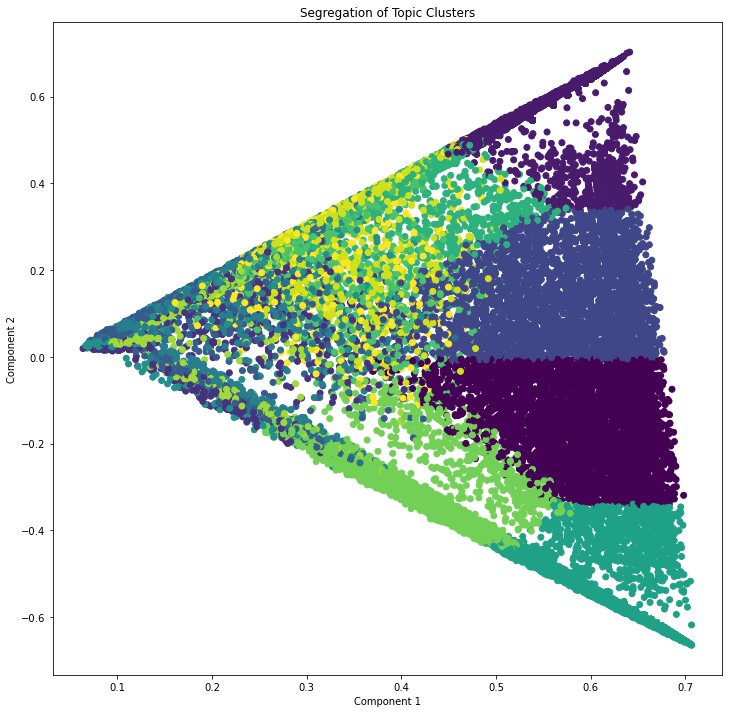

In [60]:
# Plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')

plt.title("Segregation of Topic Clusters", )

In [72]:
plt.savefig('C:/Users/Aishwik/Documents/Flip_Robo_project/clustering_vizualization.png')

<Figure size 432x288 with 0 Axes>